In [44]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
from IPython.display import clear_output
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
from dataset import download_cifar10_dataset
dataset = download_cifar10_dataset()

from dataset import load_dataset_splits
x_train, y_train, x_test, y_test = load_dataset_splits()

Dataset Downloading ...
Downloaded CIFAR-10 dataset to  c:\Users\brigh\Documents\ucsd\stuff\cifar-nb\datasets
======> CIFAR-10 dataset loaded
Training set data shape:  (50000, 3, 32, 32)
Training set label shape:  (50000,)
Test set data shape:  (10000, 3, 32, 32)
Test set label shape:  (10000,)


In [3]:
from sklearn.neighbors import KNeighborsClassifier

def run_nearest_neighbor(x_train, y_train, x_test, y_test):
    # create classifier
    nn_classifier = KNeighborsClassifier(n_neighbors=1, algorithm='auto')
    
    # train 
    nn_classifier.fit(x_train, y_train)

    # test and report accuracy
    test_acc = nn_classifier.score(x_test, y_test)
    print("Nearest neighbor accuracy on the test set: %f"%test_acc)
    
    return nn_classifier

def kmeans_cost(feat, kmeans):
    pred = kmeans.predict(feat)
    centers = kmeans.cluster_centers_[pred]
    distances = [np.linalg.norm(feat[i]-centers[i]) for i in range(len(feat))]
    cost = np.sum(distances)
    return cost

In [4]:
from extract_feature import compute_or_load_features

raw_train, raw_test = compute_or_load_features(x_train, x_test, "raw_pixel")
cnn_conv_train, cnn_conv_test = compute_or_load_features(x_train, x_test, "pretrained_cnn", "last_conv")
cnn_fc_train, cnn_fc_test = compute_or_load_features(x_train, x_test, "pretrained_cnn", "last_fc")

======> Loaded train and test features from  c:\Users\brigh\Documents\ucsd\stuff\cifar-nb\features\raw_pixel.pkl
Training feature shape:  (50000, 3072)
Test feature shape:  (10000, 3072)
======> Loaded train and test features from  c:\Users\brigh\Documents\ucsd\stuff\cifar-nb\features\pretrained_cnn_last_conv.pkl
Training feature shape:  (50000, 512)
Test feature shape:  (10000, 512)
======> Loaded train and test features from  c:\Users\brigh\Documents\ucsd\stuff\cifar-nb\features\pretrained_cnn_last_fc.pkl
Training feature shape:  (50000, 4096)
Test feature shape:  (10000, 4096)


In [23]:
raw_costs, cnn_fc_costs, cnn_conv_costs  = [], [], []
raw_test_costs, cnn_fc_test_costs, cnn_conv_test_costs  = [], [], []
raw_clusters, cnn_fc_clusters, cnn_conv_clusters = [], [], []
for i in np.arange(1,21):
    kmeans_raw = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1024, random_state=0).fit(raw_train)
    kmeans_cnn_fc = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1024, random_state=0).fit(cnn_fc_train)
    kmeans_cnn_conv = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1024, random_state=0).fit(cnn_conv_train)


    raw_costs.append(kmeans_cost(raw_train, kmeans_raw))
    cnn_fc_costs.append(kmeans_cost(cnn_fc_train, kmeans_cnn_fc))
    cnn_conv_costs.append(kmeans_cost(cnn_conv_train, kmeans_cnn_conv))

    raw_test_costs.append(kmeans_cost(raw_test, kmeans_raw))
    cnn_fc_test_costs.append(kmeans_cost(cnn_fc_test, kmeans_cnn_fc))
    cnn_conv_test_costs.append(kmeans_cost(cnn_conv_test, kmeans_cnn_conv))

    raw_clusters.append(kmeans_raw)
    cnn_fc_clusters.append(kmeans_cnn_fc)
    cnn_conv_clusters.append(kmeans_cnn_conv)

In [24]:
#training data
norm_raw_costs = np.array(raw_costs)/raw_costs[0]
norm_cnn_fc_costs = np.array(cnn_fc_costs)/cnn_fc_costs[0]
norm_cnn_conv_costs = np.array(cnn_conv_costs)/cnn_conv_costs[0]

log_raw_costs = [math.log(Ck) for Ck in norm_raw_costs]
log_cnn_fc_costs = [math.log(Ck) for Ck in norm_cnn_fc_costs]
log_cnn_conv_costs = [math.log(Ck) for Ck in norm_cnn_conv_costs]

#test data
norm_raw_test_costs = np.array(raw_test_costs)/raw_test_costs[0]
norm_cnn_fc_test_costs = np.array(cnn_fc_test_costs)/cnn_fc_test_costs[0]
norm_cnn_conv_test_costs = np.array(cnn_conv_test_costs)/cnn_conv_test_costs[0]

log_raw_test_costs = [math.log(Ck) for Ck in norm_raw_test_costs]
log_cnn_fc_test_costs = [math.log(Ck) for Ck in norm_cnn_fc_test_costs]
log_cnn_conv_test_costs = [math.log(Ck) for Ck in norm_cnn_conv_test_costs]

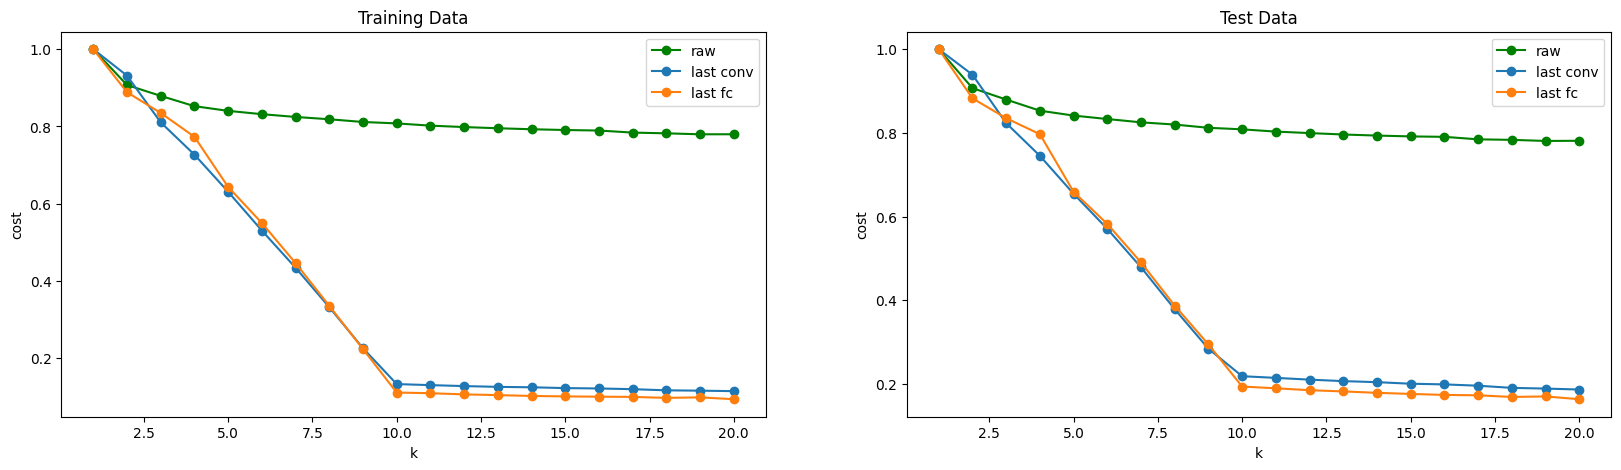

In [25]:
k_vals = np.arange(1,21)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(k_vals, norm_raw_costs, label='raw', marker='o', color='green')
ax[0].plot(k_vals, norm_cnn_conv_costs, label='last conv', marker='o')
ax[0].plot(k_vals, norm_cnn_fc_costs, label='last fc', marker='o')
ax[0].set_xlabel("k")
ax[0].set_ylabel("cost")
ax[0].set_title("Training Data")
ax[0].legend()

ax[1].plot(k_vals, norm_raw_test_costs, label='raw', marker='o', color='green')
ax[1].plot(k_vals, norm_cnn_conv_test_costs, label='last conv', marker='o')
ax[1].plot(k_vals, norm_cnn_fc_test_costs, label='last fc', marker='o')
ax[1].set_xlabel("k")
ax[1].set_ylabel("cost")
ax[1].set_title("Test Data")
ax[1].legend()

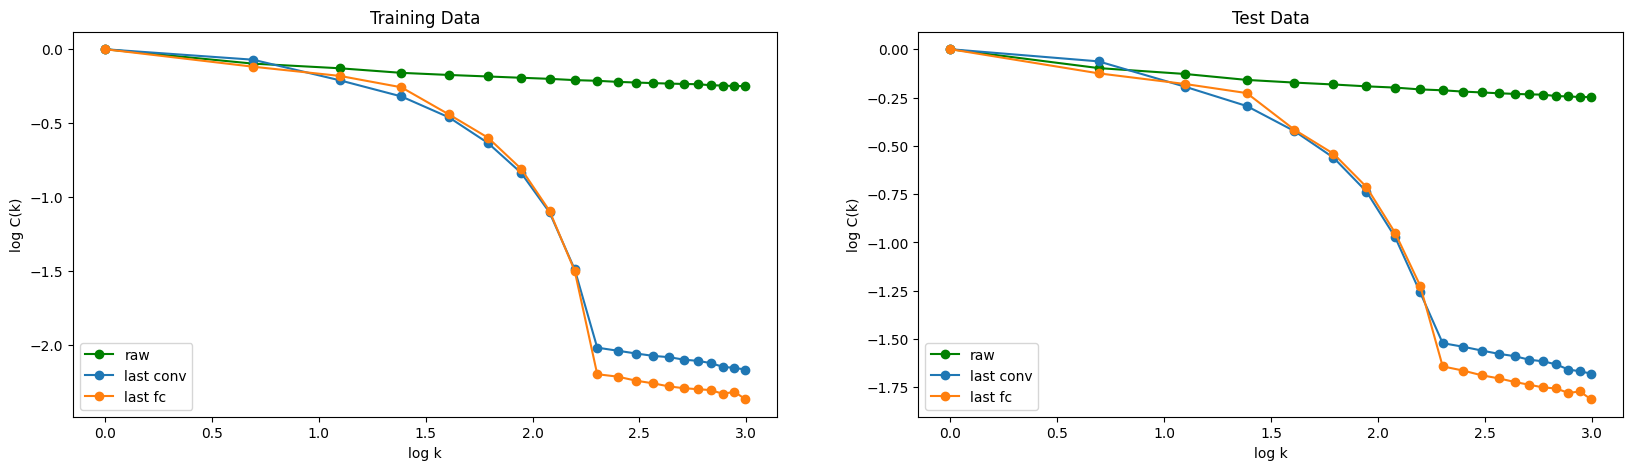

In [26]:
log_k_vals = [math.log(k) for k in np.arange(1,21)]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(log_k_vals, log_raw_costs, label='raw', marker='o', color='green')
ax[0].plot(log_k_vals, log_cnn_conv_costs, label='last conv', marker='o')
ax[0].plot(log_k_vals, log_cnn_fc_costs, label='last fc', marker='o')
ax[0].set_xlabel("log k")
ax[0].set_ylabel("log C(k)")
ax[0].set_title("Training Data")
ax[0].legend()

ax[1].plot(log_k_vals, log_raw_test_costs, label='raw', marker='o', color='green')
ax[1].plot(log_k_vals, log_cnn_conv_test_costs, label='last conv', marker='o')
ax[1].plot(log_k_vals, log_cnn_fc_test_costs, label='last fc', marker='o')
ax[1].set_xlabel("log k")
ax[1].set_ylabel("log C(k)")
ax[1].set_title("Test Data")
ax[1].legend()

In [27]:
class new_model(nn.Module):
    def __init__(self, model, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = model
        self.children_list = []
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x
    
'''self.features = features
self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

self.classifier = nn.Sequential(
    nn.Linear(512 * 1 * 1, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes),
)'''

In [32]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
summary(model, input_size=(16, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 16, 16]          128
├─ReLU: 1-3                              [16, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [16, 64, 8, 8]            --
├─Sequential: 1-5                        [16, 256, 8, 8]           --
│    └─Bottleneck: 2-1                   [16, 256, 8, 8]           --
│    │    └─Conv2d: 3-1                  [16, 64, 8, 8]            4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [16, 64, 8, 8]            --
│ 

In [34]:
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [5]:
def compute_m(i, data, labels):
    diff = data - data[i]
    dist = np.sqrt(np.sum(diff**2,axis=-1))
    indices = np.arange(data.shape[0])
    index_dist_tuples = list(zip(indices, dist))
    sorted_dists = sorted(index_dist_tuples, key=lambda tup: tup[1])

    new_list = []
    x_label = labels[i]
    labels_in_ball = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    for s,d in sorted_dists:
        labels_in_ball[labels[s]] += 1
        majority_label = max(labels_in_ball, key=labels_in_ball.get)
        if majority_label != x_label:
            break
        new_list.append((s,d))
    
    m = len(new_list) / data.shape[0]
    return m

In [63]:
from IPython.display import clear_output

data = cnn_fc_test
labels = y_test

m_vals_fc = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_fc.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        clear_output(wait=True)
        
m_vals_fc


[0.907,
 0.6657,
 0.723,
 1.0,
 0.7214,
 0.7174,
 0.8245,
 0.7213,
 0.9071,
 0.8189,
 1.0,
 0.7055,
 0.8124,
 0.7362,
 0.6605,
 0.7282,
 0.7759,
 0.7266,
 0.7453,
 0.7351,
 0.2289,
 1.0,
 0.7606,
 0.6983,
 0.0001,
 0.8024,
 0.4877,
 1.0,
 0.672,
 0.7164,
 0.766,
 0.8243,
 0.78,
 0.8259,
 0.6823,
 0.2954,
 0.7646,
 0.0002,
 0.6837,
 0.8295,
 0.7749,
 0.7528,
 0.8205,
 0.7283,
 1.0,
 0.6756,
 0.9061,
 0.0001,
 0.7231,
 0.7223,
 0.726,
 0.7562,
 1.0,
 0.9054,
 0.7339,
 0.7605,
 0.7206,
 0.0001,
 0.0002,
 0.0001,
 0.7338,
 0.0002,
 0.7155,
 0.0029,
 0.7187,
 0.7226,
 0.8189,
 0.8123,
 0.9075,
 0.7142,
 0.8155,
 0.7248,
 0.7336,
 0.745,
 1.0,
 0.8018,
 0.7301,
 0.909,
 0.246,
 0.74,
 0.7457,
 0.8189,
 0.8182,
 0.7247,
 0.8035,
 0.8017,
 0.9092,
 0.0001,
 0.7442,
 0.7185,
 1.0,
 0.904,
 0.7427,
 0.7203,
 0.7244,
 0.7639,
 0.7443,
 1.0,
 1.0,
 0.7378,
 0.6886,
 0.818,
 0.7357,
 0.9059,
 0.8178,
 0.8181,
 0.9056,
 0.7252,
 0.7456,
 0.7376,
 0.7738,
 1.0,
 0.0001,
 0.7668,
 0.8165,
 0.8865,
 1.

(array([1193.,    6.,  159.,  153.,  109.,  143.,  780., 3876., 2147.,
        1434.]),
 array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
        5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
        1.0000e+00]),
 <BarContainer object of 10 artists>)

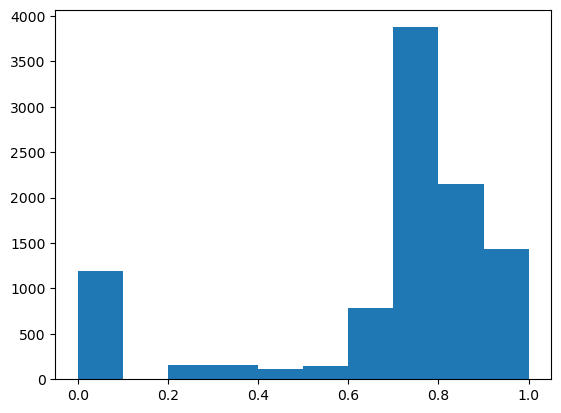

In [64]:
plt.hist(m_vals_fc)

In [65]:
np.mean(m_vals_fc), np.std(m_vals_fc)

(0.6790134200000001, 0.28094066924157424)

In [66]:
data = cnn_conv_test
labels = y_test

m_vals_conv = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_conv.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        clear_output(wait=True)
        
m_vals_conv

[0.8849,
 0.6943,
 0.7365,
 1.0,
 0.7654,
 0.7615,
 0.9215,
 0.7291,
 0.91,
 0.8859,
 1.0,
 0.6977,
 0.6644,
 0.7948,
 0.6996,
 0.7408,
 0.7093,
 0.7959,
 0.7533,
 0.7687,
 0.2127,
 1.0,
 0.8376,
 0.6982,
 0.0001,
 0.9853,
 0.3052,
 1.0,
 0.7007,
 0.772,
 0.7146,
 0.7899,
 0.5366,
 0.7825,
 0.6996,
 0.2491,
 0.4906,
 0.0002,
 0.6991,
 0.806,
 0.5067,
 0.7728,
 0.7263,
 0.757,
 1.0,
 0.7013,
 0.8307,
 0.0001,
 0.802,
 0.7608,
 0.6945,
 0.761,
 0.6349,
 0.9886,
 0.7658,
 0.7505,
 0.8024,
 0.0001,
 0.0002,
 0.0001,
 0.8178,
 0.0006,
 0.7779,
 0.0074,
 0.7516,
 0.9499,
 0.8487,
 0.9751,
 0.996,
 0.7409,
 0.815,
 0.7563,
 0.7602,
 0.7458,
 1.0,
 0.9532,
 0.733,
 0.9513,
 0.2273,
 0.7458,
 0.753,
 0.8627,
 0.8511,
 0.8054,
 0.9852,
 0.6029,
 0.9902,
 0.0001,
 0.7494,
 0.6987,
 1.0,
 0.6304,
 0.7321,
 0.7613,
 0.4657,
 0.7222,
 0.7788,
 1.0,
 1.0,
 0.7486,
 0.4689,
 0.7392,
 0.7582,
 0.9835,
 0.8486,
 0.8482,
 0.8372,
 0.7686,
 0.7757,
 0.7811,
 0.497,
 1.0,
 0.0001,
 0.9687,
 0.8642,
 0.9574

(array([1185.,    8.,  141.,  108.,  135.,  818.,  797., 3077., 1712.,
        2019.]),
 array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
        5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
        1.0000e+00]),
 <BarContainer object of 10 artists>)

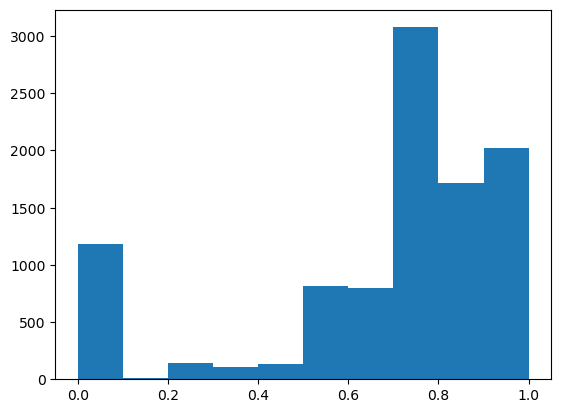

In [69]:
plt.hist(m_vals_conv)

In [70]:
np.mean(m_vals_conv), np.std(m_vals_conv)

(0.68583215, 0.291849512456981)

In [8]:
data = raw_test
labels = y_test

m_vals_raw = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_raw.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        clear_output(wait=True)
        
m_vals_raw

[0.0001,
 0.0001,
 0.0001,
 0.3522,
 0.0001,
 0.0001,
 0.0003,
 0.0002,
 0.0003,
 0.0007,
 0.0002,
 0.0001,
 0.0002,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0011,
 0.3923,
 0.0001,
 0.0001,
 0.0002,
 0.0001,
 0.0004,
 0.0503,
 0.0001,
 0.0001,
 0.0001,
 0.0002,
 0.0002,
 0.0007,
 0.0035,
 0.0002,
 0.0003,
 0.0002,
 0.0001,
 0.0001,
 0.0002,
 0.0003,
 0.0003,
 0.0007,
 0.0032,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0004,
 0.0001,
 0.0001,
 0.0002,
 0.0001,
 0.0001,
 0.0014,
 0.0001,
 0.0002,
 0.0002,
 0.0001,
 0.0001,
 0.0003,
 0.0006,
 0.0011,
 0.0001,
 0.0009,
 0.0396,
 0.0001,
 0.0038,
 0.002,
 0.0231,
 0.0001,
 0.1591,
 0.0001,
 0.1844,
 0.0001,
 0.0001,
 0.0002,
 0.0001,
 0.0001,
 0.0001,
 0.0002,
 0.0003,
 0.0003,
 0.0002,
 0.0002,
 0.0001,
 0.0001,
 0.0028,
 0.0001,
 0.011,
 0.0003,
 0.0001,
 0.0006,
 0.0001,
 0.0001,
 0.0001,
 0.0024,
 0.0275,
 0.0017,
 0.0005,
 0.0001,
 0.0001,
 0.0002,
 0.0003,
 0.0003,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0002,
 0.

(array([9.508e+03, 1.170e+02, 1.580e+02, 1.260e+02, 4.900e+01, 2.500e+01,
        2.000e+00, 1.000e+00, 2.000e+00, 1.200e+01]),
 array([1.0000e-04, 9.9610e-02, 1.9912e-01, 2.9863e-01, 3.9814e-01,
        4.9765e-01, 5.9716e-01, 6.9667e-01, 7.9618e-01, 8.9569e-01,
        9.9520e-01]),
 <BarContainer object of 10 artists>)

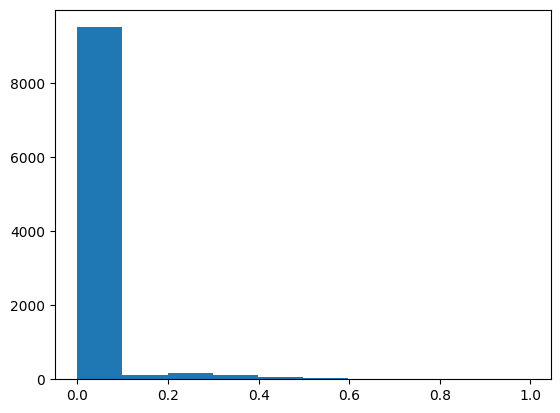

In [9]:
plt.hist(m_vals_raw)

In [10]:
np.mean(m_vals_raw), np.std(m_vals_raw)

(0.016584229999999995, 0.0751941938071491)

In [11]:
################

In [23]:
def compute_m(i, data, labels):
    diff = data - data[i]
    dist = np.sqrt(np.sum(diff**2,axis=-1))
    indices = np.arange(data.shape[0])
    index_dist_tuples = list(zip(indices, dist))
    sorted_dists = sorted(index_dist_tuples, key=lambda tup: tup[1])

    x_label = labels[i]
    labels_in_ball = {'y':0, 'other':0}
    for s,d in sorted_dists:
        if labels[s] == x_label:
            labels_in_ball['y'] += 1
        else:
            labels_in_ball['other'] += 1
        if labels_in_ball['y'] < labels_in_ball['other']:
            break
    
    m = (labels_in_ball['y'] + labels_in_ball['other']) / data.shape[0]
    return m

In [24]:
data = cnn_fc_test
labels = y_test

m_vals_fc = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_fc.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        print(m_vals_fc[-10:])
        clear_output(wait=True)
        
m_vals_fc


[0.1959,
 0.1997,
 0.1997,
 0.1993,
 0.1997,
 0.1997,
 0.1989,
 0.1997,
 0.1961,
 0.1995,
 0.1997,
 0.1991,
 0.1969,
 0.1997,
 0.1991,
 0.1997,
 0.1955,
 0.1997,
 0.1997,
 0.1997,
 0.1927,
 0.1975,
 0.1989,
 0.1991,
 0.1953,
 0.1975,
 0.1973,
 0.1997,
 0.1991,
 0.1997,
 0.1997,
 0.1971,
 0.1991,
 0.1969,
 0.1991,
 0.1933,
 0.1989,
 0.0003,
 0.1991,
 0.1965,
 0.1991,
 0.1997,
 0.1973,
 0.1997,
 0.1997,
 0.1991,
 0.1959,
 0.0003,
 0.1997,
 0.1997,
 0.1991,
 0.1997,
 0.1979,
 0.1967,
 0.1997,
 0.1997,
 0.1997,
 0.0013,
 0.0003,
 0.0003,
 0.1997,
 0.0003,
 0.1997,
 0.0013,
 0.1997,
 0.1975,
 0.1995,
 0.1975,
 0.1957,
 0.1997,
 0.1973,
 0.1997,
 0.1997,
 0.1997,
 0.1995,
 0.1975,
 0.1991,
 0.1963,
 0.1887,
 0.1997,
 0.1997,
 0.1995,
 0.1995,
 0.1997,
 0.1975,
 0.1947,
 0.1945,
 0.0007,
 0.1997,
 0.1991,
 0.1997,
 0.1963,
 0.1997,
 0.1997,
 0.1989,
 0.1997,
 0.1997,
 0.1995,
 0.1997,
 0.1997,
 0.1989,
 0.1969,
 0.1997,
 0.1959,
 0.1995,
 0.1995,
 0.1959,
 0.1997,
 0.1997,
 0.1997,
 0.1991,
 

(array([1.117e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 6.000e+00, 8.873e+03]),
 array([0.0003 , 0.02026, 0.04022, 0.06018, 0.08014, 0.1001 , 0.12006,
        0.14002, 0.15998, 0.17994, 0.1999 ]),
 <BarContainer object of 10 artists>)

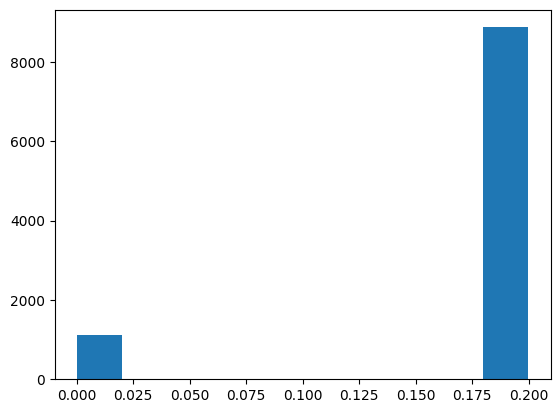

In [25]:
plt.hist(m_vals_fc)

In [26]:
np.mean(m_vals_fc), np.std(m_vals_fc)

(0.17637154, 0.062320039072744485)

In [27]:
data = cnn_conv_test
labels = y_test

m_vals_conv = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_conv.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        clear_output(wait=True)
        
m_vals_conv

[0.1947,
 0.1995,
 0.1993,
 0.1993,
 0.1995,
 0.1995,
 0.1985,
 0.1995,
 0.1943,
 0.1989,
 0.1995,
 0.1979,
 0.1967,
 0.1987,
 0.1981,
 0.1993,
 0.1941,
 0.1993,
 0.1993,
 0.1995,
 0.1923,
 0.1981,
 0.1987,
 0.1981,
 0.1959,
 0.1981,
 0.1967,
 0.1993,
 0.1981,
 0.1995,
 0.1995,
 0.1959,
 0.1979,
 0.1947,
 0.1979,
 0.1913,
 0.1979,
 0.0003,
 0.1981,
 0.1943,
 0.1979,
 0.1995,
 0.1963,
 0.1995,
 0.1995,
 0.1981,
 0.1943,
 0.0005,
 0.1995,
 0.1995,
 0.1983,
 0.1993,
 0.1961,
 0.1955,
 0.1993,
 0.1993,
 0.1995,
 0.0005,
 0.0003,
 0.0003,
 0.1993,
 0.0007,
 0.1997,
 0.0019,
 0.1995,
 0.1983,
 0.1991,
 0.1979,
 0.1939,
 0.1985,
 0.1975,
 0.1995,
 0.1993,
 0.1993,
 0.1993,
 0.1983,
 0.1989,
 0.1945,
 0.1875,
 0.1993,
 0.1993,
 0.1991,
 0.1989,
 0.1995,
 0.1983,
 0.1917,
 0.1925,
 0.0007,
 0.1993,
 0.1983,
 0.1993,
 0.1945,
 0.1993,
 0.1995,
 0.1979,
 0.1995,
 0.1997,
 0.1991,
 0.1993,
 0.1991,
 0.1979,
 0.1947,
 0.1995,
 0.1951,
 0.1991,
 0.1991,
 0.1943,
 0.1995,
 0.1993,
 0.1993,
 0.1979,
 

(array([1.143e+03, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 6.000e+00, 8.846e+03]),
 array([0.0003 , 0.02026, 0.04022, 0.06018, 0.08014, 0.1001 , 0.12006,
        0.14002, 0.15998, 0.17994, 0.1999 ]),
 <BarContainer object of 10 artists>)

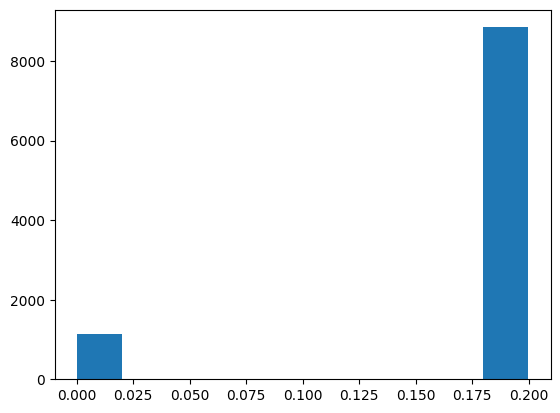

In [28]:
plt.hist(m_vals_conv)

In [29]:
np.mean(m_vals_conv), np.std(m_vals_conv)

(0.17536964000000002, 0.06279332294337035)

In [30]:
data = raw_test
labels = y_test

m_vals_raw = []
t = 0
for i in np.arange(data.shape[0]):
    m = compute_m(i, data, labels)
    m_vals_raw.append(m)

    t += 1
    if t%100 == 0:
        print('Finished', t, 'iterations...')
        clear_output(wait=True)
        
m_vals_raw

[0.0003,
 0.0005,
 0.0003,
 0.0017,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0009,
 0.0027,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0007,
 0.0005,
 0.0003,
 0.0005,
 0.0003,
 0.0003,
 0.0007,
 0.0007,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0003,
 0.0007,
 0.0005,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0003,
 0.0011,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0007,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0005,
 0.0005,
 0.0003,
 0.0007,
 0.0005,
 0.0003,
 0.0027,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0017,
 0.0003,
 0.0011,
 0.0003,
 0.0003,
 0.0005,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0031,
 0.0009,
 0.0005,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0005,
 0.0003,
 0.0003,
 0.0007,
 0.0003,
 0.0003,
 

(array([9.401e+03, 2.890e+02, 1.570e+02, 8.100e+01, 3.000e+01, 1.100e+01,
        1.900e+01, 6.000e+00, 4.000e+00, 2.000e+00]),
 array([0.0003 , 0.00146, 0.00262, 0.00378, 0.00494, 0.0061 , 0.00726,
        0.00842, 0.00958, 0.01074, 0.0119 ]),
 <BarContainer object of 10 artists>)

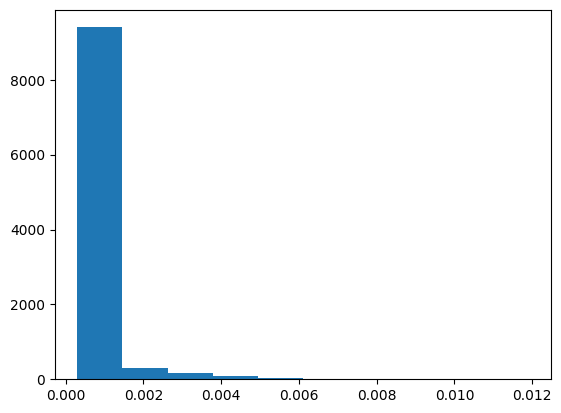

In [31]:
plt.hist(m_vals_raw)

In [32]:
np.mean(m_vals_raw), np.std(m_vals_raw)

(0.0005628, 0.0008087225482203399)

In [37]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [54]:
class new_model(nn.Module):
    def __init__(self, net, num_classes=10):
        super().__init__()
        self.net = net
        self.relu = nn.ReLU()
        self.predict = nn.Linear(1000, num_classes)
        
    def forward(self,x):
        x = self.net(x)
        x = self.relu(x)
        x = self.predict(x)
        return x

In [45]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

loader_train = DataLoader(training_data, batch_size=64, shuffle=True)
loader_val = DataLoader(test_data, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:54<00:00, 3133262.59it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [47]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [48]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy(loader_val, model)
                print()
    return check_accuracy(loader_val, model)

In [55]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
learning_rate = 1e-3
model = new_model(model, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
train(model, optimizer, epochs=10)

Epoch 0, Iteration 100, loss = 1.1620
Checking accuracy on test set
Got 6190 / 10000 correct (61.90)

Epoch 0, Iteration 200, loss = 1.2339
Checking accuracy on test set
Got 7138 / 10000 correct (71.38)

Epoch 0, Iteration 300, loss = 0.8895
Checking accuracy on test set
Got 7169 / 10000 correct (71.69)

Epoch 0, Iteration 400, loss = 0.8447
Checking accuracy on test set
Got 7513 / 10000 correct (75.13)

Epoch 0, Iteration 500, loss = 0.6795
Checking accuracy on test set
Got 7621 / 10000 correct (76.21)

Epoch 0, Iteration 600, loss = 0.8105
Checking accuracy on test set
Got 7739 / 10000 correct (77.39)

Epoch 0, Iteration 700, loss = 0.4858
Checking accuracy on test set
Got 7740 / 10000 correct (77.40)

Epoch 1, Iteration 100, loss = 0.5768
Checking accuracy on test set
Got 7975 / 10000 correct (79.75)

Epoch 1, Iteration 200, loss = 0.5647
Checking accuracy on test set
Got 7851 / 10000 correct (78.51)

Epoch 1, Iteration 300, loss = 0.7237
Checking accuracy on test set
Got 7909 / 100

KeyboardInterrupt: 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 